# Beijing air quality data forecast 

<h3>Importing essential libraries</h3>

In [103]:
import numpy as np
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
#import plotly.express as px
#import plotly.graph_objects as go

from glob import glob
from scipy import stats
from cycler import cycler
from tqdm.notebook import tqdm
from matplotlib.offsetbox import AnchoredText
#from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools  import adfuller
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_percentage_error
#from darts import TimeSeries
#from darts.dataprocessing import transformers

<b>Explain why i needed to configure matploblib settings and set memory growth on tensorflow</b>

In [59]:
mlt.rcParams['axes.spines.top'] = False
mlt.rcParams['axes.spines.right'] = False
mlt.rcParams['axes.prop_cycle'] = cycler(color = ['#365977'])

physical_devices = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('No GPU detected!')

In [11]:
folder_name = r'.\data'
data_files = glob(folder_name + r'\*.*')[1:]

for file in data_files:
    df = pd.read_csv(file)
    file_name = file.split('\\')[2]
    city_name = file_name.split('_')[2]
    print(city_name + ': ' + str(df.shape))

Aotizhongxin: (35064, 18)
Changping: (35064, 18)
Dingling: (35064, 18)
Dongsi: (35064, 18)
Guanyuan: (35064, 18)
Gucheng: (35064, 18)
Huairou: (35064, 18)
Nongzhanguan: (35064, 18)
Shunyi: (35064, 18)
Tiantan: (35064, 18)
Wanliu: (35064, 18)
Wanshouxigong: (35064, 18)


<b>Only choosing one data to work with</b>

In [12]:
dataframe = pd.read_csv(data_files[0])
dataframe.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [13]:
dataframe_copy = dataframe.drop(columns=['No', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'])
dataframe_copy.isnull().sum()

year        0
month       0
day         0
hour        0
PM2.5     925
PM10      718
SO2       935
NO2      1023
CO       1776
O3       1719
TEMP       20
dtype: int64

In [14]:
def fillNan(series):
    array = np.array(series, dtype=np.float32)
    
    count = 0
    length_of_array = len(array)
    for i in tqdm(range(length_of_array)):
        if (np.isnan(array[i])):
            prev_ = i if i == 0 else array[i - 1] 
            next_ = 0 if i == (length_of_array - 1) else array[i + 1]
            next_ = prev_ if np.isnan(next_) else next_
            array[i] = (prev_ + next_) / 2
            count += 1
    print(f'Filled row count: {count}')
    
    series = pd.Series(array)
    return series

In [15]:
dataframe_copy['NO2'] = fillNan(dataframe_copy['NO2'])
dataframe_copy['PM2.5'] = fillNan(dataframe_copy['PM2.5'])
dataframe_copy['PM10'] = fillNan(dataframe_copy['PM10'])
dataframe_copy['SO2'] = fillNan(dataframe_copy['SO2'])
dataframe_copy['CO'] = fillNan(dataframe_copy['CO'])
dataframe_copy['O3'] = fillNan(dataframe_copy['O3'])
dataframe_copy['TEMP'] = fillNan(dataframe_copy['TEMP'])

  0%|          | 0/35064 [00:00<?, ?it/s]

Filled row count: 1023


  0%|          | 0/35064 [00:00<?, ?it/s]

Filled row count: 925


  0%|          | 0/35064 [00:00<?, ?it/s]

Filled row count: 718


  0%|          | 0/35064 [00:00<?, ?it/s]

Filled row count: 935


  0%|          | 0/35064 [00:00<?, ?it/s]

Filled row count: 1776


  0%|          | 0/35064 [00:00<?, ?it/s]

Filled row count: 1719


  0%|          | 0/35064 [00:00<?, ?it/s]

Filled row count: 20


In [16]:
format = '%Y-%m-%d %H:%M:%S'
dataframe_copy['datetime'] = pd.to_datetime(dataframe_copy['year'].astype(str) + '-' + \
                                                dataframe_copy['month'].astype(str) + '-' + \
                                                    dataframe_copy['day'].astype(str) + ' ' + \
                                                        dataframe_copy['hour'].astype(str) + ':00:00' , format=format)
dataframe_copy.set_index(pd.DatetimeIndex(dataframe_copy['datetime']), inplace=True)

In [17]:
dataframe_copy.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,datetime
datetime,,,,,,,,,,,,
2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,2013-03-01 00:00:00
2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,2013-03-01 01:00:00
2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,2013-03-01 02:00:00
2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,2013-03-01 03:00:00
2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,2013-03-01 04:00:00


In [18]:
dataframe_copy.isnull().sum()

year        0
month       0
day         0
hour        0
PM2.5       0
PM10        0
SO2         0
NO2         0
CO          0
O3          0
TEMP        0
datetime    0
dtype: int64

In [19]:
dataframe_copy['quarterly'] = dataframe_copy['datetime'].apply(lambda x: x.quarter)

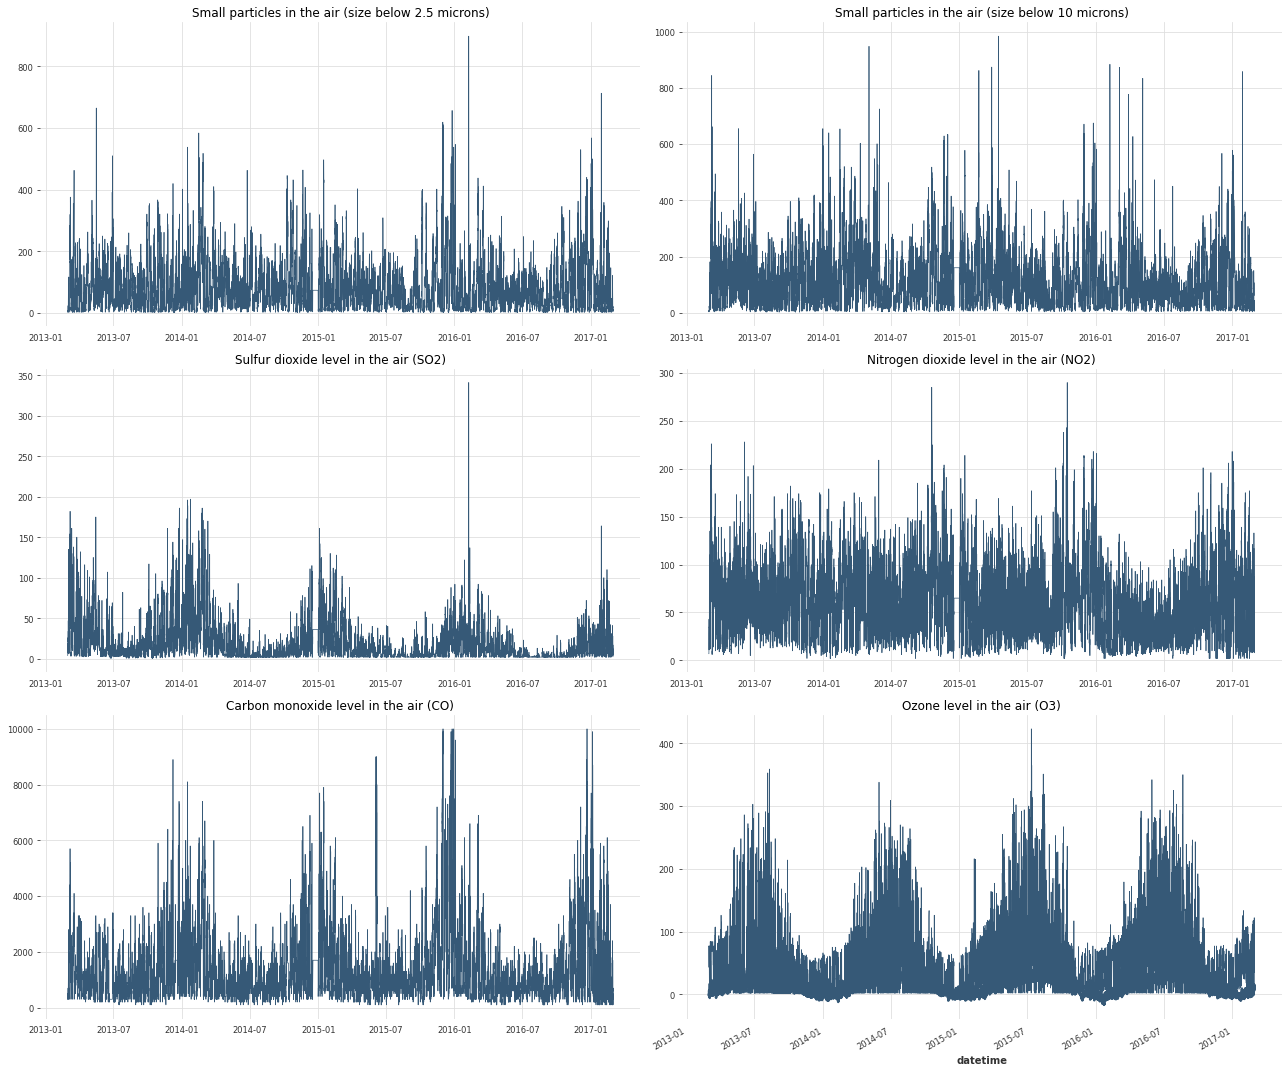

In [74]:
columns = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
titles = ['Small particles in the air (size below 2.5 microns)',
             'Small particles in the air (size below 10 microns)',
                 'Sulfur dioxide level in the air (SO2)',
                     'Nitrogen dioxide level in the air (NO2)',
                         'Carbon monoxide level in the air (CO)', 
                             'Ozone level in the air (O3)']

n = 1
fig = plt.figure(figsize=(18, 15))
for col in columns:
    ax = fig.add_subplot(3, 2, n)
    ax.set_title(titles[n - 1], size=12)
    ax.plot(dataframe_copy[col], lw=0.7)
    n += 1
    
plt.subplots_adjust(left=0.1, bottom=0.1, right=1., top=1., wspace=0.5, hspace=0.5)
plt.show()

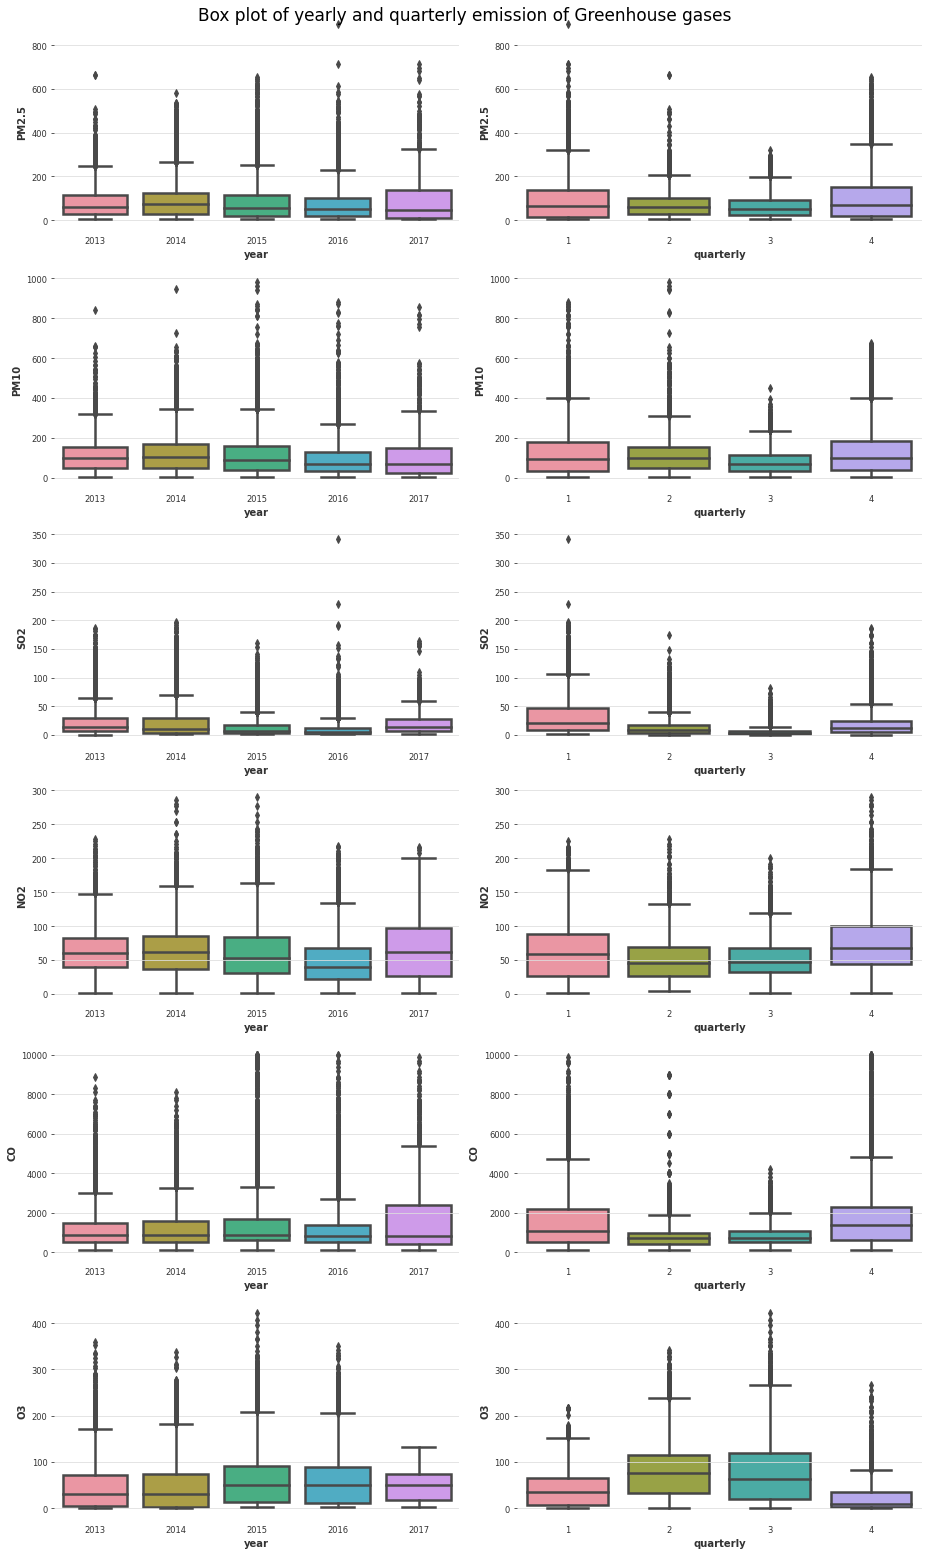

In [96]:
n = 1
fig = plt.figure(figsize=(13, 22))
for col in columns:
    ax_1 = fig.add_subplot(6, 2, n)
    sns.boxplot(x='year', y=col, data=dataframe_copy, ax=ax_1)
    ax_2 = fig.add_subplot(6, 2, n + 1)
    sns.boxplot(x='quarterly', y=col, data=dataframe_copy, ax=ax_2)
    n += 2
    
plt.suptitle('Box plot of yearly and quarterly emission of Greenhouse gases', size=17)
plt.subplots_adjust(left=0.1, bottom=0.1, right=1., top=1.5, wspace=2.5, hspace=2.5)
plt.show()

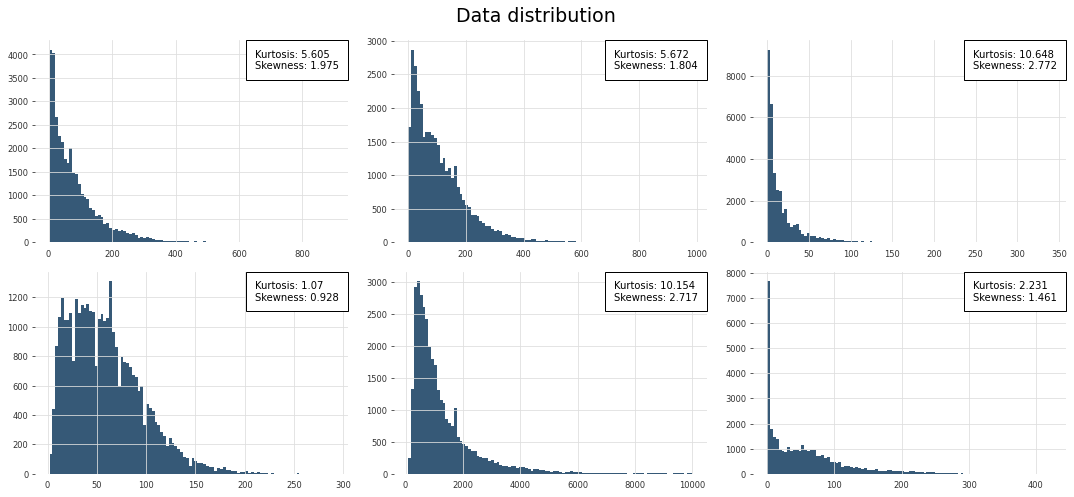

In [109]:
n = 1
fig = plt.figure(figsize=(15, 7))
for col in columns:
    ax = fig.add_subplot(2, 3, n)
    ax.hist(dataframe_copy[col], bins=100)
    n += 1
    
    annotation = AnchoredText(f"Kurtosis: {np.round(stats.kurtosis(dataframe_copy[col]), 3)}" + \
                                      f"\nSkewness: {np.round(stats.skew(dataframe_copy[col]), 3)}",
                                            prop=dict(size=10), frameon=True, loc="upper right")
    annotation.patch.set_boxstyle("square, pad=0.5")
    ax.add_artist(annotation)
    
plt.suptitle('Data distribution', size=19)
plt.subplots_adjust(left=0.1, bottom=0.1, right=1., top=1.5, wspace=2.5, hspace=2.5)
plt.show()

Text(0.5, 1.0, 'Trend of temperature')

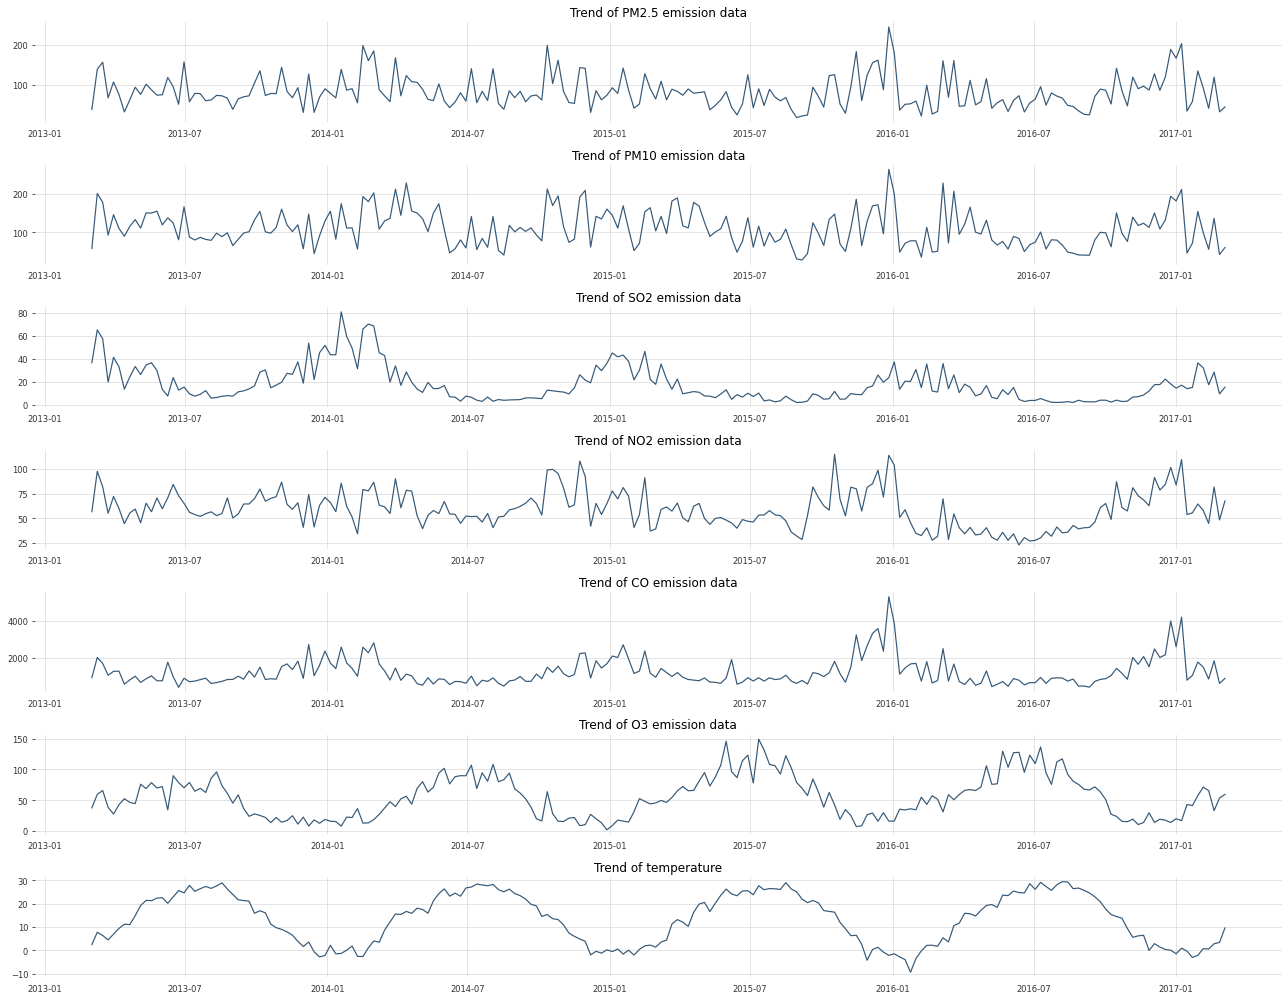

In [152]:
i, columns = 1, ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP']
fig = plt.figure(figsize=(18, 14))
for col in columns:
    ax = fig.add_subplot(7, 1, i)
    ax.set_title(f'Trend of {col} emission data')
    ax.plot(dataframe_copy[col].resample('W').mean(), lw=1.2)
    i += 1
ax.set_title(f'Trend of temperature')

<h3>Resampling data by days</h3>

In [166]:
dataframe_main = dataframe_copy.drop(columns=['year', 'month', 'day', 'hour', 'TEMP', 'datetime', 'quarterly'])
columns = dataframe_main.columns

for col in tqdm(columns):
    dataframe_main[col] = dataframe_main[col].resample('D').mean()
dataframe_main.dropna(inplace=True)
dataframe_main.head()

  0%|          | 0/6 [00:00<?, ?it/s]

,PM2.5,PM10,SO2,NO2,CO,O3
datetime,,,,,,
2013-03-01,7.125000,10.750000,11.708333,22.583334,429.166656,63.875000
2013-03-02,30.750000,42.083332,36.625000,66.666664,824.916687,29.750000
2013-03-03,76.916664,120.541664,61.291668,81.000000,1620.625000,19.125000
2013-03-04,22.708334,44.583332,22.854166,46.187500,606.250000,53.750000
2013-03-05,148.875000,183.791672,93.875000,132.833328,2357.958252,68.458336


<h3>Testing stationary state of datasets</h3>

In [191]:
print('Dickey-Fuller test results: ')
for col in columns:
    res = np.round(adfuller(dataframe_main[col], autolag="AIC")[1], 3)
    print(f'{col}: {"Data is stationary" if res < 0.05 else "Not stationary"}')

Dickey-Fuller test results: 
PM2.5: Data is stationary
PM10: Data is stationary
SO2: Data is stationary
NO2: Data is stationary
CO: Data is stationary
O3: Not stationary
